In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

tf.test.is_gpu_available()

2.0.0-dev20191002
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0-dev20191002
tensorflow_core.keras 2.2.4-tf
Instructions for updating:
Use `tf.config.experimental.list_physical_devices('GPU')` instead.


False

In [2]:
# 在打开网址时出现和ssl证书相关的问题时，需要加上这句话
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# 采用房屋预测模型数据
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
import pprint
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [5]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test = train_test_split(
    housing.data,housing.target,random_state = 7)
x_train,x_valid,y_train,y_valid = train_test_split(
    x_train_all,y_train_all,random_state = 11)
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [6]:
print(np.max(x_train),np.min(x_train))

28566.0 -124.3


In [7]:
# 进行数据归一化处理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

In [8]:
print(np.max(x_train_scaled),np.min(x_train_scaled))

81.80221745207753 -2.3594398206242224


In [9]:
x_train.shape[1:]

(8,)

In [10]:
# 使用子类Api来实现模型
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel,self).__init__()
        """定义模型层次"""
        self.hidden_layer1 = keras.layers.Dense(30,activation='relu')
        self.hidden_layer2 = keras.layers.Dense(30,activation='relu')
        self.output_layer = keras.layers.Dense(1)
    
    def call(self,input):
        """完成模型计算"""
        hidden1 = self.hidden_layer1(input)
        hidden2 = self.hidden_layer2(hidden1)
        concat = keras.layers.concatenate([input,hidden2])
        ouput = self.output_layer(concat)
        
        return ouput

# model = WideDeepModel() # 这种是直接使用子类模型来创建model

# 也可以使用下面这种序列模型来创建模型
model = keras.models.Sequential([
    WideDeepModel(),
])

model.build(input_shape=(None,8))

optimizer = keras.optimizers.Adam()
# 这个房价预测问题属于回归问题，使用的mse均方根误差损失函数
model.compile(loss="mean_squared_error", 
              optimizer = optimizer)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wide_deep_model (WideDeepMod multiple                  1239      
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [12]:
callbacks = [
    keras.callbacks.EarlyStopping(min_delta=1e-2,patience=5)
]

# 开始训练:使用归一化的数据
history = model.fit(x_train_scaled,y_train,epochs=100,
          validation_data=(x_valid_scaled,y_valid),
          callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 72us/sample - loss: 1.1730 - val_loss: 0.5608
Epoch 2/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4628 - val_loss: 0.5183
Epoch 3/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4134 - val_loss: 0.4122
Epoch 4/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3805 - val_loss: 0.4065
Epoch 5/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3722 - val_loss: 0.4086
Epoch 6/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3597 - val_loss: 0.3788
Epoch 7/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.3494 - val_loss: 0.3956
Epoch 8/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3473 - val_loss: 0.3914
Epoch 9/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.336

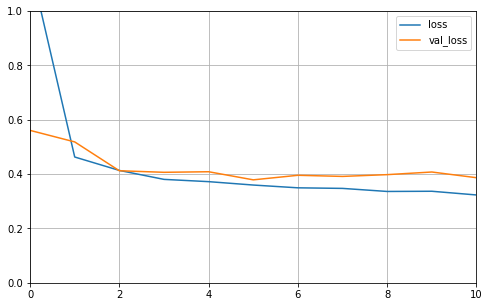

In [13]:
# 把值的变化过程打印出来
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [14]:
model.evaluate(x_test_scaled,y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.397363527292429